# Micrograd

Micrograd is an AutoGrad (auto differentication) library built for pedegogical purpose. This is made to understand the neural network training process especially backprop.

**References**

[Github link](https://github.com/karpathy/micrograd)

In [209]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [210]:
def f(x):
    return 3*x**2 - 4*x + 5 

In [211]:
f(3.0)

20.0

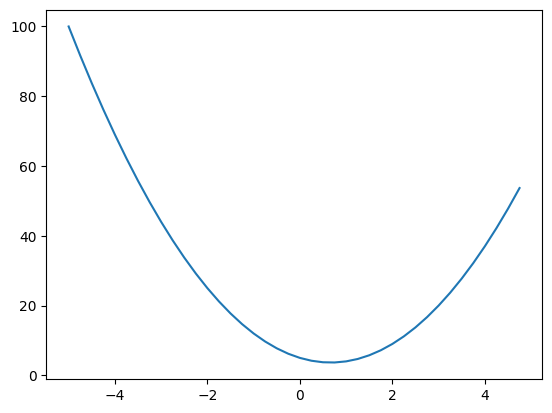

In [212]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys); # semicoln at end makes the command output only the plot without prining the object id

Implementing derivative of the function manually.

Derivative by definition is the change in the function/(slope of a function) when you slightly bump up the function by a small value h
$$\text{Derivative:}  \frac{f(x+h)-f(x)}{h}$$

In [213]:
h  = 0.00000001
x = -3.0
(f(x+h) - f(x))/h

-22.00000039920269

In [214]:
# more complex function with more variables
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [215]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
print(f"{d1=}")

a = 2.0
b = -3.0
c = 10.0
c += h
d2 = a*b + c
print(f"{d2=}")
print("slope=", (d2-d1)/h)

d1=4.0
d2=4.0001
slope= 0.9999999999976694


**Value class**

In [216]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def backward():
            self.grad += (1 - t**2)*out.grad

        out._backward=backward

        return out


In [217]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


Toy example

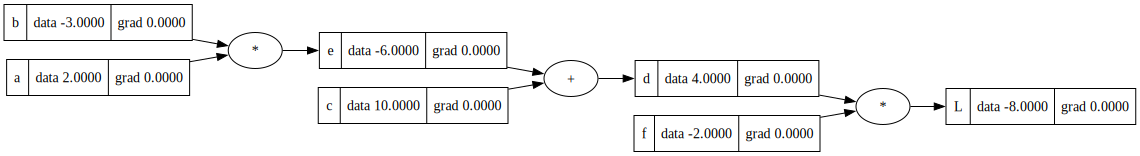

In [218]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
# print(L)
draw_dot(L)

**More realistic example: Neuron**
$$y = f_{activation}(wx+b)$$

**Activation function: tanh**
Tanh function squashes the input value between -1 and 1. 

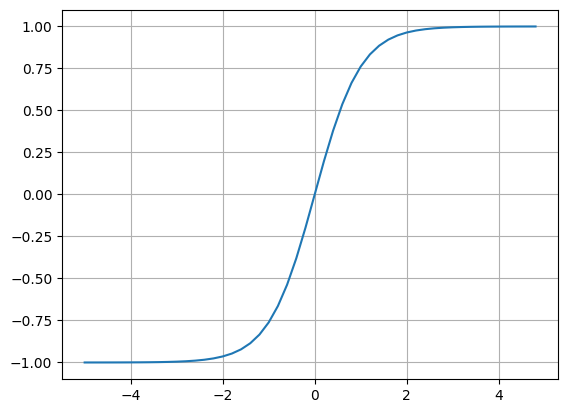

In [219]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

**Manual backprop**: We will do manual backprob with an objective to find the derivative $\frac{do}{dw_1},\frac{do}{dw_2}$. i.e gradient of the change in output with respect to weigths

In [220]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh(); o.label='o'

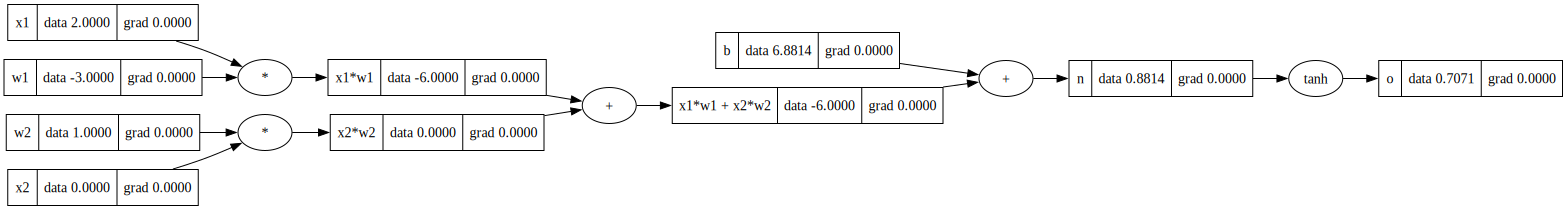

In [221]:
draw_dot(o)

In [222]:
# Start at output compute do/do: which is 1
o.grad = 1.0

# Next: o=tanh(n); find do/dn 
#  dtanh(n)/dx = 1-tanh(n)**2 = 1 - o**2
n.grad = 1-o.data**2

# Next Addition operation: n= x1*w1+x2*w2 + b 
# local gradient for b: dn/db = 1
# local gradient for x1*w1+x2*w2 : dn/d(x1*w1+x2*w2) = 1
# do/db = dn/db * do/dn (by chain rule) => 1 * 0.5 = 0.5
# do/d(x1*w1+x2*w2) = 1*0.5 = 0.5
# Conclusion: for addition operation the local gradient is 1. 
# For gradient with respect to output the gradient from previous step flows to this step
x1w1x2w2.grad = 1.0 * n.grad
b.grad = 1.0 * n.grad

# Next Addition operation: x1w1x2w2 = x1w1 + x2w2
# Similar to previous step: flow the gradients from previous step
x2w2.grad = 1.0 * x1w1x2w2.grad
x1w1.grad= 1.0 * x1w1x2w2.grad

# Next 2 Mulitplication operations x1w1=x1*w1 and x2w2=x2*w2
# Computing local gradients: 
# d(x1w1)/dx1 = w1; d(x1w1)/dw1 = x1;
# d(x2w2)/dx2 = w2; d(x2w2)/dw = x2;
# Conclusion: for multiplication operation the gradient with respect to one varaiable is value of other variable
# Gradient with respect to output is product of previous step gradient and the value of other variable
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad

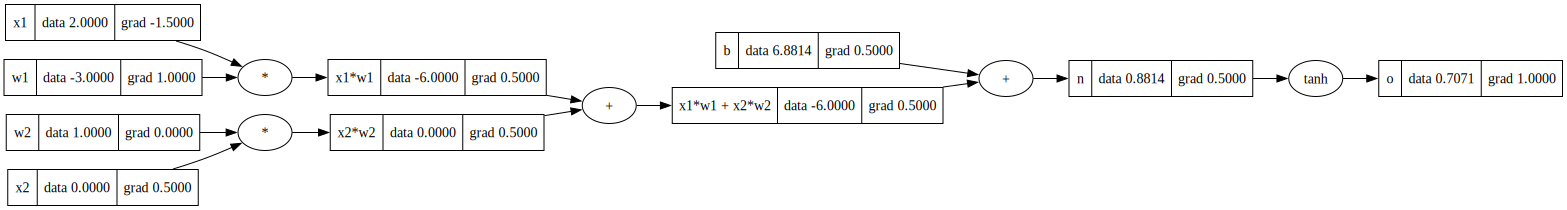

In [223]:
draw_dot(o)

**Semi-automated Backprop:** Node level automation of backprop by adding backward function to Value class

In [224]:
####################
## Initialization ##
####################
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh(); o.label='o'

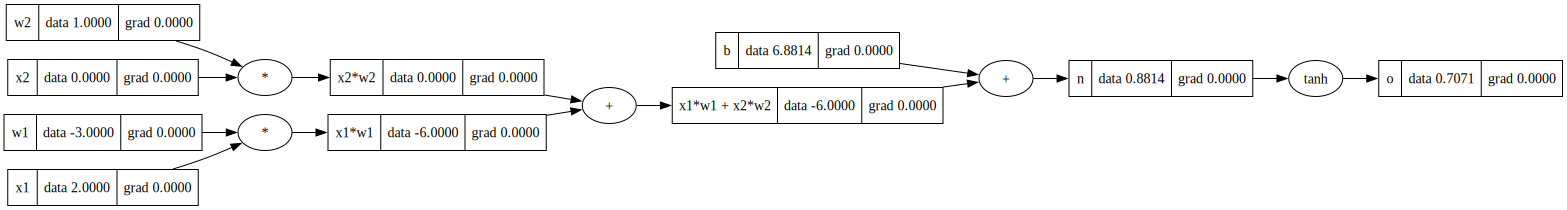

In [225]:
draw_dot(o)

In [226]:

# Initialize output gradient to 1.0
o.grad = 1.0
# call backwards on each step
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
w1._backward()
x2._backward()
w2._backward()


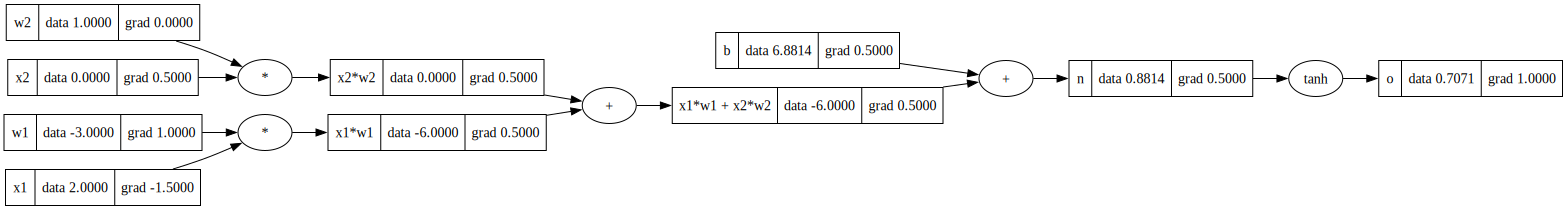

In [227]:
draw_dot(o)

**Fully-Automatee Backprop:** Fully automate the backprop by calling the backward function of each node (starting from output) all the way to the input (i.e reverse topological order.)

Graph toplogical sort is useful algorithm to order achieve the topological ordering of nodes in graph

In [228]:
####################
## Initialization ##
####################
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weigths w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n = x1w1x2w2 + b ; n.label='n'
o = n.tanh(); o.label='o'

In [229]:
topo=[]
visited = set()
def build_topo(n):
    visited.add(n)
    # print("Entering node:",n.label)
    for prev in n._prev:
        # print("Going through prev node:",prev.label)
        build_topo(prev)
    # print("Adding node:",n.label)
    topo.append(n)

build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

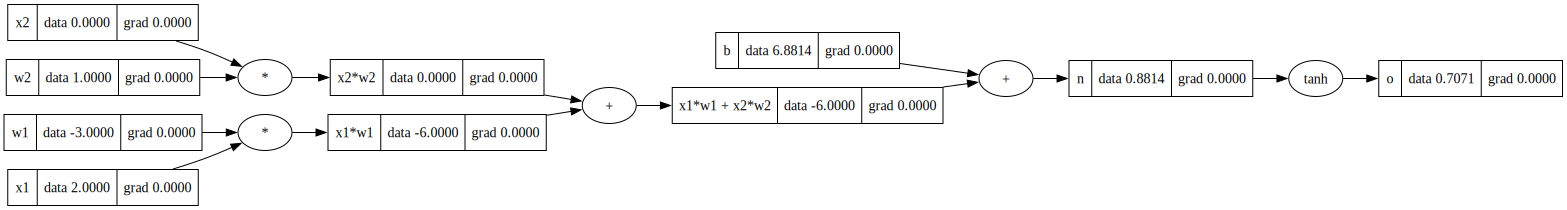

In [230]:
draw_dot(o)

In [231]:
o.grad = 1.0
for n in reversed(topo):
    n._backward()

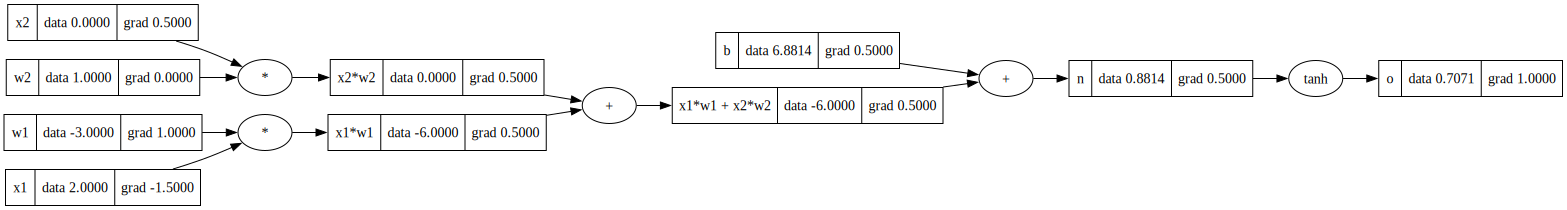

In [232]:
draw_dot(o)

Comparing our Value class implementation agains `pytorch`

In [233]:
import torch

x1 = torch.tensor(2.0).double(); x1.requires_grad=True
w1 = torch.tensor(-3.0).double(); w1.requires_grad=True
x2 = torch.tensor(0.0).double(); x2.requires_grad=True
w2 = torch.tensor(1.0).double(); w2.requires_grad=True
b = torch.tensor(6.8813735870195432).double(); b.requires_grad=True
n = x1*w1 + x2*w2 + b

o=torch.tanh(n)
o.backward()

print(f"{o.item()=}")
print("------")
print(f"{x1.grad.item()=}")
print(f"{w1.grad.item()=}")
print(f"{x2.grad.item()=}")
print(f"{w2.grad.item()=}")
# print(f"{b.grad=}")

o.item()=0.7071066904050358
------
x1.grad.item()=-1.5000003851533106
w1.grad.item()=1.0000002567688737
x2.grad.item()=0.5000001283844369
w2.grad.item()=0.0


The gradients and outputs match exactly to the version of network we build with Value class

**Improving the capabilities of the Value class**

Adding more operations like divide, exponentiation, power etc...

In [234]:
a = Value(1.0)
a + 1

AttributeError: 'int' object has no attribute 'data'

In [247]:
class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) 
        out = Value(self.data + other.data, (self, other), "+")
        
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        
        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other

    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self,other):
        # other = other if isinstance(other, Value) else Value(other)
        return self + (-other)

    def __rsub__(self,other): #other - self
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only support int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def backward():
            n = other
            self.grad += n * self.data ** (n-1) * out.grad
        out._backward = backward

        return out

    def __truediv__(self,other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def backward():
            self.grad += (1 - t**2)*out.grad

        out._backward=backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def backward():
            self.grad += out.data * out.grad 
        out._backward = backward

        return out

    def backward(self):    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [248]:
a = Value(1.0)
a + 1

a * 4, 4 * a, a + 2

(Value(data=4.0), Value(data=4.0), Value(data=3.0))

**Building Neural Nets from Value class**

Define the building blocks of neural net

1. **Neuron**

    An Artificial neuron is a function that maps inputs to outputs. For a neuron with n inputs x the output $$y = \sum_{i=1}^{n}(w_i*x_i) + b$$

    $x_i$ - input of neuron i = 1..n 
    $w_i$ - weights associated with each input i = 1..n
    $b$  - bias of the neuron

In [269]:
import random

"""
An Artificial neuron is a function that maps inputs to outputs. For a neuron with 
n inputs x the output y = sum(wi*xi) + b

xi - input of neuron i = 1..n
wi - weights associated with each input i = 1..n
b  - bias of the neuron
"""
class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


2. Layer

In [270]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


3. Multi Layer Perceptron (MLP)

In [271]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [279]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.28707313342560725)

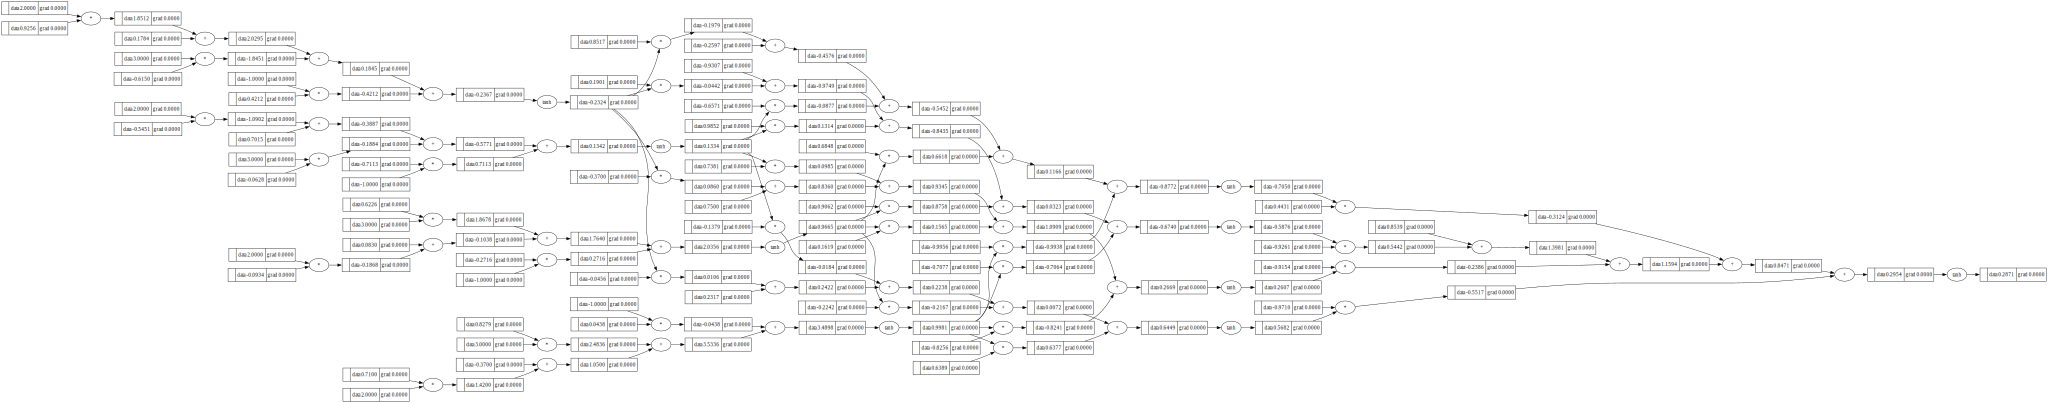

In [280]:
draw_dot(n(x))

In [281]:
n.parameters()

[Value(data=0.9255750621617311),
 Value(data=-0.6150183931663815),
 Value(data=0.421169364731278),
 Value(data=0.17838815345348058),
 Value(data=-0.5450880223339529),
 Value(data=-0.06279463527298579),
 Value(data=-0.711305189856765),
 Value(data=0.7014592354121103),
 Value(data=-0.09338781160576959),
 Value(data=0.6226090210288784),
 Value(data=-0.2715703721136584),
 Value(data=0.08296760404151104),
 Value(data=0.7099898279865813),
 Value(data=0.8278821371378045),
 Value(data=0.04382501501434777),
 Value(data=-0.3700078461519736),
 Value(data=0.19014251213776934),
 Value(data=0.9852334435532053),
 Value(data=0.906182361768644),
 Value(data=-0.7076780142443204),
 Value(data=-0.9307241506517008),
 Value(data=-0.36998181236364314),
 Value(data=0.7380961488621709),
 Value(data=0.16189626648764266),
 Value(data=-0.8256226543431981),
 Value(data=0.7500362854201053),
 Value(data=0.8517072922080497),
 Value(data=-0.6571304276306955),
 Value(data=0.6848140461536276),
 Value(data=-0.99563678173

**Simple Binary Classifier**

In [253]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.6519810261397053),
 Value(data=0.3438989993208627),
 Value(data=0.40633816931550365),
 Value(data=0.5492559650311358)]

Training loop

In [300]:
 # Loss function: Mean Squared Error(MSE)

for _ in range(20):
    # forward pass
    yout = [n(x) for x in xs]
    loss = sum([(yt - yp)**2  for yt, yp in zip(ys, yout)])
    print(f"{loss.data=}")

    # zero gradients
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # parameter update
    lr = 0.05
    for p in n.parameters():
        p.data += -lr * p.grad

loss.data=0.004366592249394367
loss.data=0.004325307589714153
loss.data=0.004284779474271555
loss.data=0.0042449875063539505
loss.data=0.0042059120114361715
loss.data=0.004167534005631796
loss.data=0.0041298351657786435
loss.data=0.004092797801061141
loss.data=0.004056404826078289
loss.data=0.004020639735272108
loss.data=0.003985486578637649
loss.data=0.003950929938639961
loss.data=0.003916954908269181
loss.data=0.0038835470701686437
loss.data=0.0038506924767756053
loss.data=0.003818377631418051
loss.data=0.0037865894703138494
loss.data=0.0037553153454231605
loss.data=0.0037245430081071732
loss.data=0.0036942605935489604


In [301]:
yout

[Value(data=0.9851171900912699),
 Value(data=-0.9664419963156267),
 Value(data=-0.9649122038249179),
 Value(data=0.9666013546522461)]